<a href="https://colab.research.google.com/github/hegone/urban-pollution-trends-ml/blob/main/LSTM_PM25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/200
1378/1378 [==============================] - 8s 5ms/step - loss: 0.0136
Epoch 2/200
1378/1378 [==============================] - 6s 4ms/step - loss: 0.0110
Epoch 3/200
1378/1378 [==============================] - 6s 4ms/step - loss: 0.0101
Epoch 4/200
1378/1378 [==============================] - 6s 4ms/step - loss: 0.0098
Epoch 5/200
1378/1378 [==============================] - 6s 4ms/step - loss: 0.0097
Epoch 6/200
1378/1378 [==============================] - 6s 4ms/step - loss: 0.0095
Epoch 7/200
1378/1378 [==============================] - 6s 4ms/step - loss: 0.0096
Epoch 8/200
1378/1378 [==============================] - 6s 4ms/step - loss: 0.0096
Epoch 9/200
1378/1378 [==============================] - 6s 4ms/step - loss: 0.0095
Epoch 10/200
1378/1378 [==============================] - 6s 4ms/step - loss: 0.0095
Epoch 11/200
1378/1378 [==============================] - 6s 4ms/step - loss: 0.0095
Epoch 12/200
1378/1378 [==============================] - 6s 4ms/step - lo

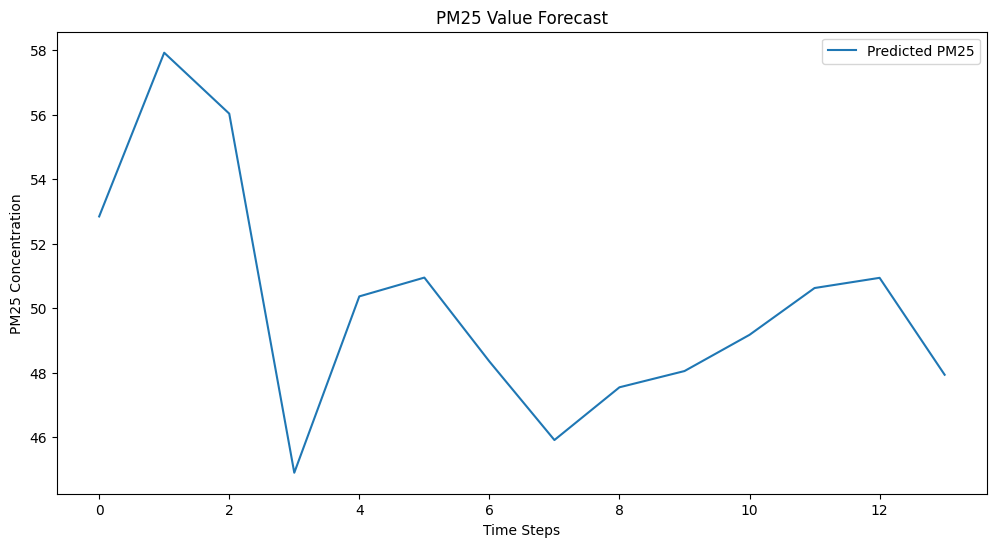

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Air Quality Forecast/London/Cleaned_London_Air_Quality.csv') # replace with adequate file location

# Convert date column to datetime and filter data from 2020 onwards
data['date'] = pd.to_datetime(data['date'])
data = data[data['date'].dt.year >= 2020]

# 'pm25' is the column you want to forecast
values = data[['pm25']].values

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Specify the input and output time steps
n_input = 14
n_features = 1

# Define generator
generator = TimeseriesGenerator(scaled, scaled, length=n_input, batch_size=1)

from keras.models import Sequential
from keras.layers import Dense, LSTM

# Define the model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Fit the model
model.fit(generator, epochs=200, verbose=1)

import matplotlib.pyplot as plt

# Forecast
pred_list = []
batch = scaled[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

# Inverse transform to get the real value
predicted_pm25_values = scaler.inverse_transform(pred_list)

# Visualize the forecast
plt.figure(figsize=(12, 6))
plt.plot(range(len(predicted_pm25_values)), predicted_pm25_values, label='Predicted PM25')
plt.title('PM25 Value Forecast')
plt.xlabel('Time Steps')
plt.ylabel('PM25 Concentration')
plt.legend()
plt.show()


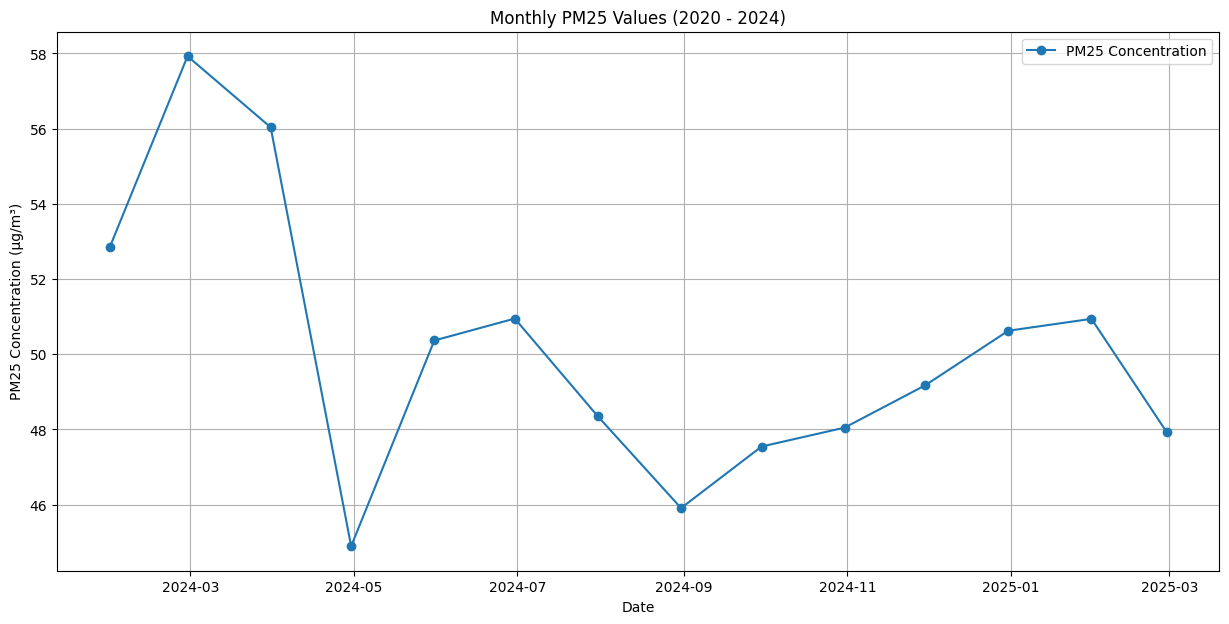

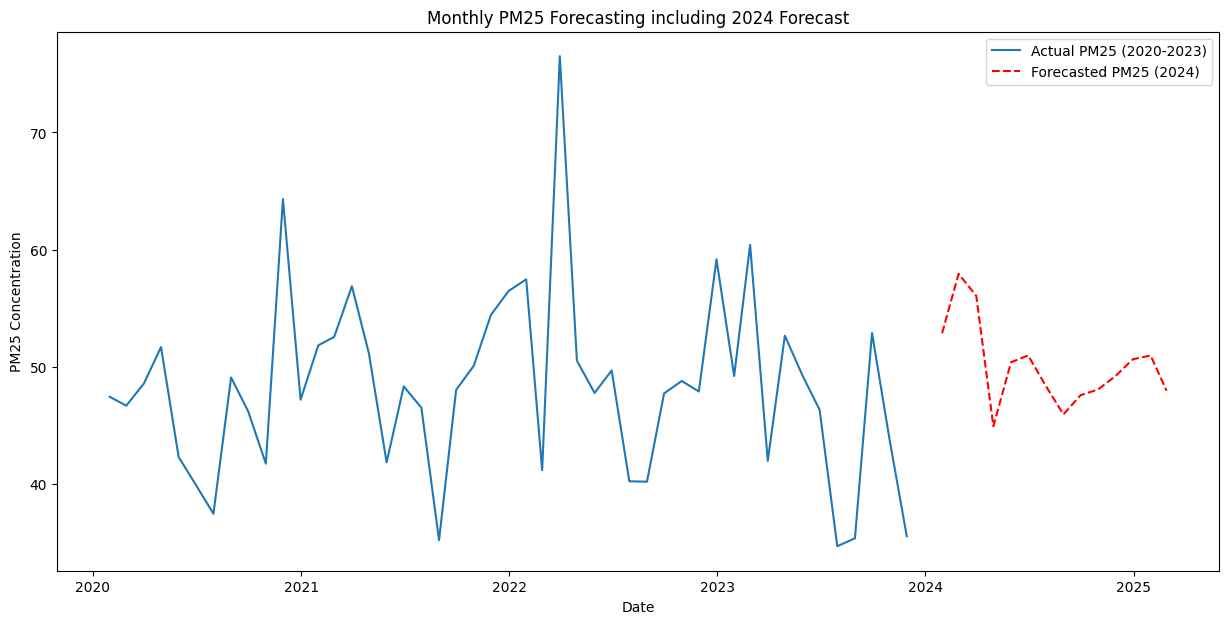

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Air Quality Forecast/London/Cleaned_London_Air_Quality.csv') # replace with adequate file location
df['date'] = pd.to_datetime(df['date'])

# Aggregate to monthly data and filter for 2020 onwards
df = df.set_index('date')
df_monthly_pm25 = df['pm25'].resample('M').mean()
df_monthly_pm25 = df_monthly_pm25[df_monthly_pm25.index.year >= 2020]

# Forecasted data from the LSTM model
# This should be a list or array of predicted values from the LSTM model.
forecasted_pm25_values = predicted_pm25_values.flatten()  # Flatten in case it's a 2D array from the scaler

# Create a date range for the forecasted data, this should match your forecasted periods
forecast_dates = pd.date_range(start='2024-01-01', periods=len(forecasted_pm25_values), freq='M')

# Create a DataFrame for the forecasted data
forecast_data = pd.DataFrame({
    'date': forecast_dates,
    'pm25': forecasted_pm25_values
})

# Combine the historical and forecasted data
combined_data = pd.concat([df_monthly_pm25, forecast_data], ignore_index=True)

# Plotting the forecasted PM25 values
plt.figure(figsize=(15, 7))
plt.plot(combined_data['date'], combined_data['pm25'], marker='o', label='PM25 Concentration')
plt.title('Monthly PM25 Values (2020 - 2024)')
plt.xlabel('Date')
plt.ylabel('PM25 Concentration (μg/m³)')
plt.legend()
plt.grid(True)
plt.show()

# Visualize
plt.figure(figsize=(15, 7))
plt.plot(df_monthly_pm25.index, df_monthly_pm25.values, label='Actual PM25 (2020-2023)')
plt.plot(forecast_dates, forecast_data.pm25, label='Forecasted PM25 (2024)', linestyle='--', color='red')
plt.title('Monthly PM25 Forecasting including 2024 Forecast')
plt.xlabel('Date')
plt.ylabel('PM25 Concentration')
plt.legend()
plt.show()



Evaluate with RMSE

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import math

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Air Quality Forecast/London/Cleaned_London_Air_Quality.csv') # replace with adequate file location
df['date'] = pd.to_datetime(df['date'])

# Aggregate to monthly data and filter for 2020 onwards
df = df.set_index('date')
df_monthly_pm25 = df['pm25'].resample('M').mean()
df_monthly_pm25 = df_monthly_pm25[df_monthly_pm25.index.year >= 2020]

# Normalize the monthly data
scaler_pm25 = MinMaxScaler(feature_range=(0, 1))
scaled_pm25 = scaler_pm25.fit_transform(df_monthly_pm25.values.reshape(-1, 1))

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Converts time series data to a supervised learning dataset.

    Arguments:
    - data: Sequence of observations as a list or NumPy array.
    - n_in: Number of lag observations as input (X).
    - n_out: Number of observations as output (y).
    - dropnan: Boolean whether or not to drop rows with NaN values.

    Returns:
    - Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Convert to supervised learning problem
reframed_pm25 = series_to_supervised(scaled_pm25, 1, 1)

# Split into train and test sets
values_pm25 = reframed_pm25.values
train_pm25, test_pm25 = train_test_split(values_pm25, test_size=0.2, random_state=42)

# Split into input and outputs
train_X_pm25, train_y_pm25 = train_pm25[:, :-1], train_pm25[:, -1]
test_X_pm25, test_y_pm25 = test_pm25[:, :-1], test_pm25[:, -1]

# Reshape input to be 3D for LSTM [samples, timesteps, features]
train_X_pm25 = train_X_pm25.reshape((train_X_pm25.shape[0], 1, train_X_pm25.shape[1]))
test_X_pm25 = test_X_pm25.reshape((test_X_pm25.shape[0], 1, test_X_pm25.shape[1]))

# Predict and inverse transform to evaluate
predictions_pm25 = model.predict(test_X_pm25).flatten()
predictions_pm25 = scaler_pm25.inverse_transform(predictions_pm25.reshape(-1, 1)).flatten()
actual_pm25 = scaler_pm25.inverse_transform(test_y_pm25.reshape(-1, 1)).flatten()

# Calculate RMSE, MAE, MAPE
rmse_pm25 = math.sqrt(mean_squared_error(actual_pm25, predictions_pm25))
mae_pm25 = mean_absolute_error(actual_pm25, predictions_pm25)
mape_pm25 = np.mean(np.abs((actual_pm25 - predictions_pm25) / actual_pm25)) * 100

print('Test RMSE: %.3f' % rmse_pm25)
print('Test MAE: %.3f' % mae_pm25)
print('Test MAPE: %.3f%%' % mape_pm25)


1/1 [==============================] - 0s 197ms/step
Test RMSE: 22.746
Test MAE: 22.278
Test MAPE: 48.839%


Very high RMSE value meaning inaccurate forecast

Generate outputfile

In [ ]:
import pandas as pd

forecasted_pm25_values = predicted_pm25_values.flatten()  # Flatten in case it's a 2D array from the scaler

# Create a DataFrame for the forecasted data
forecast_output = pd.DataFrame({
    'Forecast': forecasted_pm25_values,
    'Lower CI': forecasted_pm25_values * 0.9,  # Placeholder for lower confidence interval
    'Upper CI': forecasted_pm25_values * 1.1   # Placeholder for upper confidence interval
})

# Assuming forecast is for the entire 2024, generating dates for each month
forecast_index = pd.date_range(start='2024-01-01', periods=len(forecasted_pm25_values), freq='M')
forecast_output.index = forecast_index

# Save forecast data to a CSV file
forecast_output_path = '/content/drive/MyDrive/Air Quality Forecast/London/LSTM/PM25_Forecast_2024.csv' # replace with adequate file location
forecast_output.to_csv(forecast_output_path)

print(f"Forecast output saved to {forecast_output_path}")



Forecast output saved to /content/drive/MyDrive/Air Quality Forecast/London/LSTM/PM25_Forecast_2024.csv
